In [1]:
import numpy as np
import nlpaug.augmenter.word as naw
import itertools
import pandas as pd
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None
from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install torchdata==0.5.0 -q
!pip install sacremoses -q
!pip install transformers -q
!pip install datasets -q
!pip install pytorch_metric_learning -q
!pip install sentence_transformers -q
!pip install numpy requests nlpaug -q

In [4]:
from torchtext import datasets
from torch.utils.data import DataLoader

In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/NLP_Projekt/
from RobertaContrastiveModel import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MojePliki/Studia aktualne/NLP_Projekt


# Tests

In [7]:
from torchtext._internal.module_utils import is_module_available
is_module_available("torchdata")

True

In [8]:
yelp_train = datasets.YelpReviewPolarity(split = 'train')
yelp_test = datasets.YelpReviewPolarity(split = 'test')

In [9]:
train_dataloader = DataLoader(yelp_train, batch_size=100, shuffle=False)

In [10]:
labels, sentences = next(iter(train_dataloader))

In [11]:
df = pd.DataFrame({'sentence':sentences, 'label':labels})
df['label'][df.label == 1] = 0
df['label'][df.label == 2] = 1

# Utils

In [6]:
def augment_dataset(df, method='none', n=1, p=1/3):
    STOPWORDS = ['br','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'one', 
             'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
             'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
             'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
             'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thats', 'would',
             "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
             'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 
             'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
             'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
             'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
             'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
             'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
             'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
             'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    if method=='none':
        return df
    elif method=='synonym':
        aug = naw.SynonymAug(aug_src='wordnet',aug_min=int(len(df.sentence[0])*p), stopwords=STOPWORDS)
        new_sentences = []
        new_labels = []
        for i in range(len(df)):
            augmented = aug.augment(df.sentence[i], n=n)
            for elem in augmented:
                new_sentences.append(elem)
                new_labels.append(df.label[i])
        new_sentences = new_sentences + list(df.sentence)
        new_labels = new_labels + list(df.label)
        new_df = pd.DataFrame({'sentence':new_sentences, 'label':new_labels})
        return new_df
    elif method=='context':
        aug = naw.ContextualWordEmbsAug(
            model_path='bert-base-uncased', action="substitute", device='cuda',
                aug_min=int(len(df.sentence[0])*p), stopwords=STOPWORDS, batch_size = 64)
        new_sentences = aug.augment(list(df.sentence))
        new_labels = list(df.label) + list(df.label)
        new_sentences = new_sentences + list(df.sentence)
        new_df = pd.DataFrame({'sentence':new_sentences, 'label':new_labels})
        return new_df
    elif method=='translation':
        aug = naw.BackTranslationAug(
            from_model_name='facebook/wmt19-en-de', 
            to_model_name='facebook/wmt19-de-en',
            device='cuda',
            batch_size = 20,
            max_length=2000
        )
        new_sentences = aug.augment(list(df.sentence))
        new_labels = list(df.label) + list(df.label)
        new_sentences = new_sentences + list(df.sentence)
        new_df = pd.DataFrame({'sentence':new_sentences, 'label':new_labels})
        return new_df
    else:
        raise ValueError(f'Unknown augmentation method: {method}.')

In [7]:
def prepare_dataset(dataset="yelp", test=False, seed=42,):
    if dataset == 'imdb':
        df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[:200,:]
        if test:
            df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[1000:10000,:]
        df = df.rename(columns={'review': 'sentence', 'sentiment': 'label'})
        df['label'][df.label == 'positive'] = 1
        df['label'][df.label == 'negative'] = 0
    elif dataset == 'yelp':
        yelp_train = datasets.YelpReviewPolarity(split = 'train')
        if test:
            size = 9000
        else:
            size = 200
        train_dataloader = DataLoader(yelp_train, batch_size=size, shuffle=False)
        labels, sentences = next(iter(train_dataloader))
        df = pd.DataFrame({'sentence':sentences, 'label':labels})
        df['label'][df.label == 1] = 0
        df['label'][df.label == 2] = 1
    else:
        raise ValueError(f'Cannot load the dataset: {dataset}.')
    df = shuffle(df, random_state=seed)
    return df

In [8]:
def cross_validate(args):
    augmentation = args.augmentation
    n_aug = args.n_aug
    p = args.p_aug
    seed = args.seed
    max_length = args.max_length
    learning_rate = args.learning_rate
    num_warmup_steps = args.num_warmup_steps
    num_training_steps = args.num_training_steps
    eps = args.eps
    model_name = args.model_name
    model_type = args.model_type
    weight_decay = args.weight_decay
    la = args.la
    gamma = args.gamma
    margin = args.margin
    centers = args.centers
    beta = args.beta
    save_steps = args.save_steps
    sample_size = args.sample_size
    n_split = args.n_split
    supcon_temp = args.supcon_temp
    np.random.seed(seed)
    dataset_name = args.dataset_name
    softmax_scale = args.softmax_scale
    alpha = args.alpha
    extended_inference = args.extended_inference

    training_args = TrainingArguments(
        output_dir=args.output_dir,
        num_train_epochs=args.epochs,
        per_device_train_batch_size=args.per_device_train_batch_size,
        per_device_eval_batch_size=args.per_device_eval_batch_size,
        save_steps=save_steps
    )

    kf = KFold(n_splits=n_split, random_state=seed, shuffle=True)
    cross_val_res = {}
    df = prepare_dataset(dataset_name)
    df = augment_dataset(df, method=augmentation, n=n_aug, p=p)

    if model_name == "roberta-base":
        embedding_size = 768
    else:
        embedding_size = 1024

    for fold_id, (train_index, valid_index) in enumerate(kf.split(df)):
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        train_dataset = CLDatasetClassification(train_index, df, tokenizer, max_length, sample_size)
        valid_dataset = CLDatasetClassification(valid_index, df, tokenizer, max_length)
        if model_type == "softriple":
            clf_loss = losses_ml.SoftTripleLoss(num_classes=len(unique(df.label)), embedding_size=embedding_size,
                                             centers_per_class=centers, la=la, gamma=gamma, margin=margin)
        elif model_type == "supcon":
            clf_loss = losses_ml.SupConLoss(temperature=supcon_temp)
        elif model_type == "proxynca":
            clf_loss = losses_ml.ProxyNCALoss(len(unique(df.label)), embedding_size=embedding_size,
                                           softmax_scale=softmax_scale)
        elif model_type == "proxyanchor":
            clf_loss = losses_ml.ProxyAnchorLoss(len(unique(df.label)), embedding_size=embedding_size, margin=margin,
                                              alpha=alpha)
        elif model_type == "npairs":
            clf_loss = losses_ml.NPairsLoss()
        elif model_type == "triplet":
            clf_loss = BatchAllTripletLoss()
        elif model_type == "baseline":
            clf_loss = None
        else:
            raise ValueError(
                f'The model_type: {model_type} is not supported. Choose one of following: triple_entropy, supcon, baseline.')
        model = RobertaContrastiveLearning.from_pretrained(model_name,
                                                           num_labels=len(
                                                               unique(df.label)),
                                                           clf_loss=clf_loss,
                                                           beta=beta,
                                                           extended_inference=extended_inference)
        param_groups = [{"params": model.parameters(),
                         'lr': float(learning_rate)}]

        optimizer = transformers.AdamW(param_groups, eps=eps, weight_decay=weight_decay, correct_bias=True)
        scheduler = transformers.get_cosine_schedule_with_warmup(optimizer=optimizer,
                                                                 num_warmup_steps=num_warmup_steps,
                                                                 num_training_steps=num_training_steps)
        optimizers = optimizer, scheduler
        set_seed(seed)

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            optimizers=optimizers,
            compute_metrics=compute_metrics
        )

        trainer.train()
        cross_val_res[fold_id] = trainer.evaluate()
        #trainer.save_model(args.output_dir + f'{fold_id}_{model_name}_{model_type}_{dataset_name}/model')
    results = []
    for measure in ["eval_f1_score", "eval_recall_score", "eval_accuracy_score", "eval_precision_score"]:
        m = np.mean([el[measure] for el in cross_val_res.values()])
        std = np.std([el[measure] for el in cross_val_res.values()])
        results.append([m,std])

    #print(f"Model type: {model_type}, Dataset name: {dataset_name}")
    #for measure in ["eval_f1_score", "eval_recall_score", "eval_accuracy_score", "eval_precision_score"]:
    #    print(
    #        f'measure: {measure.split("_")[1]}, mean: {np.mean([el[measure] for el in cross_val_res.values()])}, std: {np.std([el[measure] for el in cross_val_res.values()])}')
    return results, trainer

# Data augmentations

In [14]:
df = pd.read_csv("/content/drive/MyDrive/NLP_Projekt/IMDB Dataset.csv").iloc[2000:2100,:]
df = df.rename(columns={'review': 'sentence', 'sentiment': 'label'})
df['label'][df.label == 'positive'] = 1
df['label'][df.label == 'negative'] = 0

In [15]:
df = df.reset_index(drop=True)

In [16]:
sum(df.label)

51

In [17]:
STOPWORDS = ['br','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'one', 
             'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
             'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
             'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
             'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thats', 'would',
             "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
             'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 
             'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
             'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
             'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
             'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
             'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
             'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
             'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [59]:
# aug = naw.SynonymAug(aug_src='wordnet',aug_min=int(len(df.sentence[0])/3), stopwords=STOPWORDS)
aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en',
    device='cuda',
    max_length=10000
)
# aug = naw.ContextualWordEmbsAug(
#     model_path='bert-base-uncased', action="substitute", device='cuda',aug_min=int(len(df.sentence[0])/3), stopwords=STOPWORDS)
# augmented_text = aug.augment(text)

In [60]:
%%time
augmented = aug.augment(list(df.sentence)[0])

CPU times: user 4.82 s, sys: 280 ms, total: 5.1 s
Wall time: 5.34 s


In [61]:
augmented[0]

'"Stranded in Space" (1972) MST3K version - a very bad TV movie pilot, for a never-to-be-realized series in which an astronaut is trapped on Earth\'s evil twin. "Having a planet of identical size and a mass orbit in the same plane as Earth, but on the other side of the Sun, is a well-worn SF chestnut" - the idea is more than 2000 years old and was invented by the ancient Greeks. In this version, the opposite world is led as an Orwellian "perfect" society, where, for entirely inexplicable reasons, everyone speaks English and drives late American model cars. "After escaping from his prison-like hospital, the disturbing Earthman is turned off by television and the bad movie star Cameron Mitchell, who wears double-breasted suits and black polo-tail jumpers - a stylistically evil combination that I will wholeheartedly embrace if I ever become a totalitarian overlord.'

In [29]:
%%time
new_sentences = []
new_labels = []
for i in range(len(df)):
    augmented = aug.augment(df.sentence[i])
    for elem in augmented:
        new_sentences.append(elem)
        new_labels.append(df.label[i])

CPU times: user 2.81 s, sys: 3.01 ms, total: 2.81 s
Wall time: 2.81 s


# Model hyperparameters

In [11]:
def create_args(n, use_rlarge, augmentation='none', n_aug=1, p_aug=1/3, n_split=2):
    if use_rlarge:
        modeln = "roberta-large"
    else:
        modeln = "roberta-base"

    args = Namespace(
        augmentation = augmentation,
        n_aug = n_aug,
        p_aug = p_aug,
        max_length = 64,
        learning_rate=1e-5,
        num_warmup_steps=10,
        eps=1e-08,
        model_name=modeln,
        model_type="softriple",
        weight_decay=0.01,
        la=8,
        supcon_temp=0.1,
        gamma=0.1,
        margin=0.1,
        centers=5,
        beta=0.4,
        seed=2048,
        output_dir="./result",
        save_steps=1000,
        epochs=100,
        num_training_steps=100,
        per_device_train_batch_size=50,
        per_device_eval_batch_size=50,
        sample_size=n,
        n_split=n_split,
        dataset_name="yelp",
        softmax_scale=1,
        alpha=0.1,
        extended_inference=0.1)
    return args

# Base model training

In [112]:
args = create_args(100, False, augmentation='none')

In [ ]:
%%capture
results, trainer = cross_validate(args)

In [114]:
print('valid acc: ', results[2][0], 'std: ', results[2][1])
print('valid f1: ', results[0][0], 'std: ', results[0][1])

valid acc:  0.84 std:  0.010000000000000009
valid f1:  0.8410590858416946 std:  0.007146042363433691


In [119]:
df = prepare_dataset('yelp', True)

In [ ]:
%%capture
tokenizer = tokenizer = AutoTokenizer.from_pretrained("roberta-base")
test_dataset = CLDatasetClassification(np.arange(len(df)), df, tokenizer, 64)

In [121]:
pred = trainer.predict(test_dataset=test_dataset)
pred.metrics

***** Running Prediction *****
  Num examples = 9000
  Batch size = 50


{'test_loss': 0.3395444452762604,
 'test_accuracy_score': 0.8263333333333334,
 'test_f1_score': 0.8263107244054098,
 'test_recall_score': 0.8809073724007561,
 'test_precision_score': 0.7787758512638395,
 'test_runtime': 32.0722,
 'test_samples_per_second': 280.617,
 'test_steps_per_second': 5.612}

# Model with synonym augmentation training

In [129]:
args = create_args(150, False, augmentation='synonym', n_aug=1, p_aug=1/3)

In [ ]:
%%capture
results, trainer = cross_validate(args)

In [131]:
print('valid acc: ', results[2][0], 'std: ', results[2][1])
print('valid f1: ', results[0][0], 'std: ', results[0][1])

valid acc:  0.8425 std:  0.007500000000000007
valid f1:  0.8429327523521413 std:  0.007067247647858765


In [132]:
df = prepare_dataset('yelp', True)

In [ ]:
%%capture
tokenizer = tokenizer = AutoTokenizer.from_pretrained("roberta-base")
test_dataset = CLDatasetClassification(np.arange(len(df)), df, tokenizer, 64)

In [134]:
pred = trainer.predict(test_dataset=test_dataset)
pred.metrics

***** Running Prediction *****
  Num examples = 9000
  Batch size = 50


{'test_loss': 0.405620813369751,
 'test_accuracy_score': 0.8336666666666667,
 'test_f1_score': 0.832829856883917,
 'test_recall_score': 0.7733931947069943,
 'test_precision_score': 0.8588297034898976,
 'test_runtime': 34.8305,
 'test_samples_per_second': 258.394,
 'test_steps_per_second': 5.168}

# Model with context embedding augmentation training

In [135]:
args = create_args(150, False, augmentation='context', p_aug=1/3)

In [ ]:
%%capture
results, trainer = cross_validate(args)

In [137]:
print('valid acc: ', results[2][0], 'std: ', results[2][1])
print('valid f1: ', results[0][0], 'std: ', results[0][1])

valid acc:  0.9125000000000001 std:  0.007500000000000007
valid f1:  0.9110217398879584 std:  0.007323848347335793


In [138]:
df = prepare_dataset('yelp', True)

In [ ]:
%%capture
tokenizer = tokenizer = AutoTokenizer.from_pretrained("roberta-base")
test_dataset = CLDatasetClassification(np.arange(len(df)), df, tokenizer, 64)

In [140]:
pred = trainer.predict(test_dataset=test_dataset)
pred.metrics

***** Running Prediction *****
  Num examples = 9000
  Batch size = 50


{'test_loss': 0.469973623752594,
 'test_accuracy_score': 0.8188888888888889,
 'test_f1_score': 0.815598012410223,
 'test_recall_score': 0.694234404536862,
 'test_precision_score': 0.8973732437385461,
 'test_runtime': 34.8677,
 'test_samples_per_second': 258.118,
 'test_steps_per_second': 5.162}

In [147]:
del trainer

# Model with back-translation augmentation training

In [16]:
torch.cuda.empty_cache()

In [17]:
args = create_args(150, False, augmentation='translation')

In [ ]:
%%capture
results, trainer = cross_validate(args)

In [19]:
print('valid acc: ', results[2][0], 'std: ', results[2][1])
print('valid f1: ', results[0][0], 'std: ', results[0][1])

valid acc:  0.89 std:  0.040000000000000036
valid f1:  0.8908986749474554 std:  0.037984515935735486


In [20]:
df = prepare_dataset('yelp', True)

In [ ]:
%%capture
tokenizer = tokenizer = AutoTokenizer.from_pretrained("roberta-base")
test_dataset = CLDatasetClassification(np.arange(len(df)), df, tokenizer, 64)

In [22]:
pred = trainer.predict(test_dataset=test_dataset)
pred.metrics

***** Running Prediction *****
  Num examples = 9000
  Batch size = 50


{'test_loss': 0.4223640263080597,
 'test_accuracy_score': 0.8254444444444444,
 'test_f1_score': 0.8255993598448228,
 'test_recall_score': 0.84617202268431,
 'test_precision_score': 0.7956009775605422,
 'test_runtime': 34.8762,
 'test_samples_per_second': 258.056,
 'test_steps_per_second': 5.161}

# Plot model performance based on augmentation strength

In [ ]:
accs = []
f1s = []
ps = np.linspace(0,1,11)
df = prepare_dataset('yelp', True)
tokenizer = tokenizer = AutoTokenizer.from_pretrained("roberta-base")
test_dataset = CLDatasetClassification(np.arange(len(df)), df, tokenizer, 64)
counter = 0
for p in ps:
    args = create_args(200, False, augmentation='synonym', n_aug=1, p_aug=p)
    results, trainer = cross_validate(args)
    pred = trainer.predict(test_dataset=test_dataset)
    accs.append(pred.metrics['test_accuracy_score'])
    f1s.append(pred.metrics['test_f1_score'])
    del trainer
    print('ITERATION {counter} ENDED')
    counter += 1

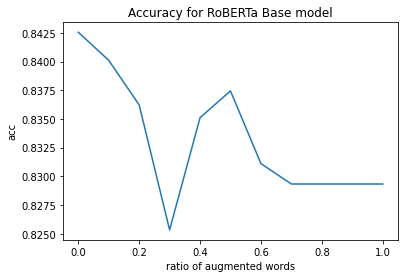

In [16]:
plt.plot(ps,accs)
plt.title('Accuracy for RoBERTa Base model')
plt.xlabel('ratio of augmented words')
plt.ylabel('acc')
plt.show()

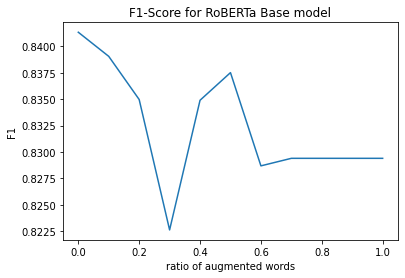

In [17]:
plt.plot(ps,f1s)
plt.title('F1-Score for RoBERTa Base model')
plt.xlabel('ratio of augmented words')
plt.ylabel('F1')
plt.show()